## Load contig cluster information

In [1]:
from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

base_path='/Users/evogytis/Documents/manuscripts/skeeters/data/s3/' ## where contig_quality and contig folders sit

def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)


clusters = defaultdict(list)
with open(base_path+'../500_contigs_cluster.clstr', 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member) ## load clustered contig data
            
contig2cluster={}
for cluster_id in clusters:
    for m in clusters[cluster_id]:
        contig2cluster[m.contig]=cluster_id

## Load read counts and contig LCA information

In [2]:
import os,json,glob

total_reads={}
for line in open(base_path+'../metadata/idseq_metadata.csv','r'):
    l=line.strip('\n').split(',')
    if l[0]=='sample':
        header={x:i for i,x in enumerate(l)}
    else:
        sample=l[header['sample']]
        nonhost=int(l[header['nonhost_reads']]) ## get nonhost reads
        total=int(l[header['total_reads']])
        
        if sample not in total_reads: ## sample not seen before
            total_reads[sample]=0
            
        total_reads[sample]+=nonhost ## sum non-host reads for sample
        
grand_total=sum(total_reads.values()) ## sum all of sample nonhost reads
        
contig_classification={}
for fname in glob.glob(os.path.join(base_path,'contig_quality/*/contig_stats_all.tsv')): ## iterate over all contig stats
    fsample=os.path.basename(os.path.dirname(fname))
    
    if fsample not in contig_classification: ## new sample
        contig_classification[fsample]={}
        
    for line in open(fname,'r'): ## iterate over all contigs
        l=line.strip('\n').split('\t')
        
        if l[0]=='sample':
            header={x:i for i,x in enumerate(l)}
        else:
            sample,contig,length,read_count=l
            length=int(length)
            read_count=int(read_count)
            contig_classification[sample][contig]={'read_count': read_count, 'contig_length': length, 'blasts': False, 'co-occurs': False} ## initialise contig entry under sample with read counts, length, assume contig hasn't blasted to anything and hasn't been assigned to a viral RdRp
            

for fname in glob.glob(os.path.join(base_path,'contig_quality/*/contig_stats_lca.tsv')): ## iterate over blast results
    fsample=os.path.basename(os.path.dirname(fname))
        
    for line in open(fname,'r'): ## iterate over contigs
        l=line.strip('\n').split('\t')
        
        if l[0]=='sample':
            header={x:i for i,x in enumerate(l)}
        else:
            sample=l[header['sample']] ## get sample
            contig=l[header['contig_name']] ## get contig name
            tax_group=l[header['taxon_group']] ## get taxonomic assignment
            assert sample==fsample
            
            if contig in contig_classification[sample]: ## contig seen before, all good
                if tax_group!='': ## contig blasted to something, change its status as a blasted contig, add assigned taxonomic group
                    contig_classification[sample][contig]['blasts']=True ## contig is in LCA file, therefore blasted
                    contig_classification[sample][contig]['tax_group']=tax_group ## LCA assigned taxonomic group
            else:
                print('contig %s has not been seen previously, must be an error'%(contig))
            
in_json=open(base_path+'../darkmatter/virus.json','r')
virus=json.load(in_json) ## open curated virus list

in_json.close()

for pol_group in virus: ## iterate over polymerase groups
    for seg in virus[pol_group]['segments']: ## iterate over segments of virus
        for clust in virus[pol_group]['segments'][seg]['clusters']: ## iterate over clusters that contain viral contigs
            for m in clusters[str(clust)]: ## iterate over contigs in cluster
                if contig_classification[m.sample][m.contig]['blasts']==False: ## if viral contig didn't blast it's been assigned to a viral polymerase and thus is something discovered via co-occurrence
                    contig_classification[m.sample][m.contig]['co-occurs']=True
                elif contig_classification[m.sample][m.contig]['tax_group']!='Viruses': ## viral contig not called virus
                    print('contig %s called as %s by LCA despite being virus'%(m.contig,contig_classification[m.sample][m.contig]['tax_group']))

contig NODE_1_length_17565_cov_7.309984 called as Ambiguous by LCA despite being virus
contig NODE_1_length_18277_cov_48.170824 called as Ambiguous by LCA despite being virus
contig NODE_1_length_18272_cov_59.270624 called as Ambiguous by LCA despite being virus
contig NODE_6_length_2203_cov_26.203669 called as Ambiguous by LCA despite being virus
contig NODE_6_length_2196_cov_5.627183 called as Ambiguous by LCA despite being virus
contig NODE_4_length_2420_cov_26.034571 called as Ambiguous by LCA despite being virus
contig NODE_5_length_2418_cov_6.362238 called as Ambiguous by LCA despite being virus
contig NODE_7_length_1839_cov_40.468785 called as Ambiguous by LCA despite being virus
contig NODE_20_length_689_cov_2.504902 called as Ambiguous by LCA despite being virus
contig NODE_8_length_1838_cov_42.448609 called as Ambiguous by LCA despite being virus
contig NODE_7_length_1842_cov_33.126346 called as Ambiguous by LCA despite being virus
contig NODE_4_length_2235_cov_10.352641 call

## Assign reads to treemap categories

In [3]:
category={'name': 'all reads', 'read_count': 0, 'children': [
                           {'name': 'unassembled', 'read_count': 0}, 
                           {'name': 'contigs', 'read_count': 0, 
                                   'children': [
                                       {'name': 'dark contigs', 'read_count': 0}, 
                                       {'name': 'Archaea', 'read_count': 0}, 
                                       {'name': 'Bacteria', 'read_count': 0}, 
                                       {'name': 'Ambiguous', 'read_count': 0}, 
                                       {'name': 'Eukaryota', 'read_count': 0, 'children': [
                                           {'name': 'Metazoa', 'read_count': 0}
                                       ]}, 
                                       {'name': 'Viruses', 'read_count': 0, 'children': [
                                           {'name': 'Viral via co-occurrence', 'read_count': 0}]}
                                   ]}
                      ]
         }


def getCategory(node,name,result=None):
    """
    Given a treemap dict and name of compartment returns compartment with matching name.
    """
    if 'children' in node:
        for child in node['children']:
            result=getCategory(child,name,result=result)
            
    if name==node['name']:
        result=node
    
    return result
    
unassembled_reads=grand_total-sum([sum([contig_classification[s][c]['read_count'] for c in contig_classification[s]]) for s in contig_classification])

cat=getCategory(category,'unassembled')
cat['read_count']+=unassembled_reads

for sample in contig_classification: ## iterate over samples
    for contig in contig_classification[sample]: ## iterate over contigs
        C=contig_classification[sample][contig] ## get classification for contig
        
        reads=C['read_count']
            
        if C['blasts']==True: ## contig blasted
            tax_group=C['tax_group'] ## grab assigned taxonomic group
            cat=getCategory(category,tax_group)
            
        elif C['co-occurs']==True: ## blasts==False but co-occurs==True
            assert C['blasts']==False ## to be safe that contig didn't blast
            cat=getCategory(category,'Viral via co-occurrence')
            
        else: ## didn't blast, didn't co-occur and therefore dark
            cat=getCategory(category,'dark contigs')
        
        cat['read_count']+=reads ## add reads to appropriate category of treemap
            
print(category) ## reports per-branch read counts (parents without read counts of their children yet)


def sumValues(node,stat):
    """
    Passes read counts from children to parents.
    """
    if 'children' in node:
        for child in node['children']:
            node[stat]+=sumValues(child,stat) ## traverse first (reaches tips first)
            
    return node[stat]

sumValues(category,'read_count') ## add values of children to parents


def reportStats(node,level=None):
    """
    Traverse treemap and report read counts across compartments.
    """
    if level==None:
        level=0
        note=''
    elif level==3:
        note='of which in'
    else:
        note='in'
    
    print('%s|%d\t%s %s'%(level*'   ',node['read_count'],note,node['name']))
        
    if 'children' in node:
        level+=1
        for child in sorted(node['children'],key=lambda w: -w['read_count']):
            reportStats(child,level)

print('\n\n')
reportStats(category)

{'name': 'all reads', 'read_count': 0, 'children': [{'name': 'unassembled', 'read_count': 5146208}, {'name': 'contigs', 'read_count': 0, 'children': [{'name': 'dark contigs', 'read_count': 9098225}, {'name': 'Archaea', 'read_count': 413}, {'name': 'Bacteria', 'read_count': 689595}, {'name': 'Ambiguous', 'read_count': 925854}, {'name': 'Eukaryota', 'read_count': 613462, 'children': [{'name': 'Metazoa', 'read_count': 190489}]}, {'name': 'Viruses', 'read_count': 8699045, 'children': [{'name': 'Viral via co-occurrence', 'read_count': 1585185}]}]}]}



|26948476	 all reads
   |21802268	in contigs
      |10284230	in Viruses
         |1585185	of which in Viral via co-occurrence
      |9098225	in dark contigs
      |925854	in Ambiguous
      |803951	in Eukaryota
         |190489	of which in Metazoa
      |689595	in Bacteria
      |413	in Archaea
   |5146208	in unassembled


## Plot treemap

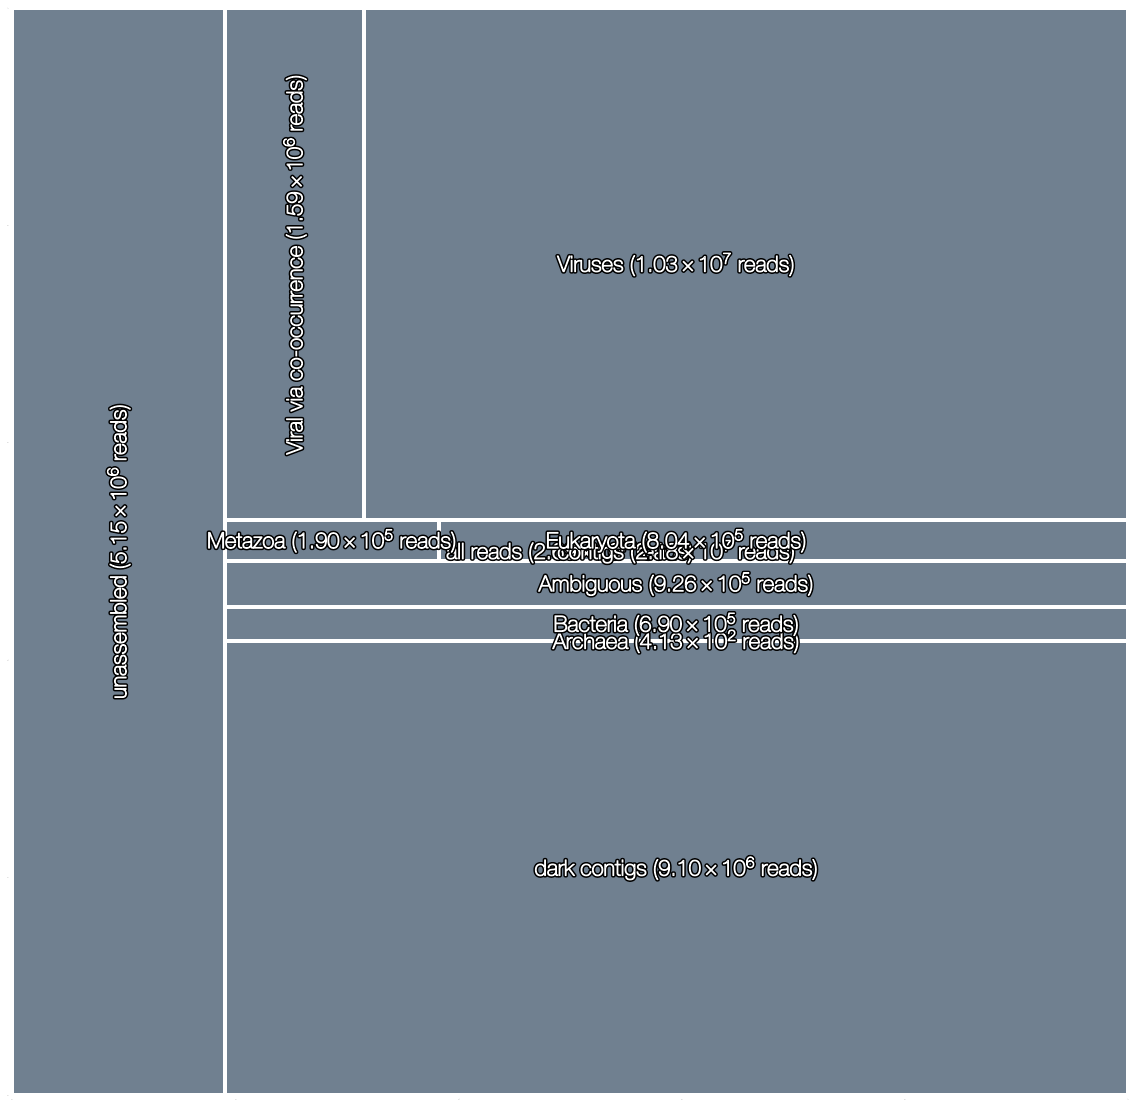

In [4]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

import numpy as np

typeface='Helvetica Neue'
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

size=lambda k: k['read_count']

def computeCoordinates(node,lower=None,upper=None,axis=None):
    """
    Computes coordinates for each compartment.
    """
    if lower==None and upper==None and axis==None:
        lower=[0,0]
        upper=[1,1]
        axis=0
        node['x']=0
        node['y']=0
        node['dx']=1
        node['dy']=1
        
    axis = axis % 2
    width = upper[axis] - lower[axis]
    height = upper[axis-1] - lower[axis-1]
    
    if 'children' in node:
        for child in node['children']: ## iterate over children
            upper[axis] = lower[axis] + (width * float(size(child)))/float(size(node))

            W = upper[0] - lower[0]
            H = upper[1] - lower[1]

            child['x']=lower[0]
            child['y']=lower[1]
            child['dx']=W
            child['dy']=H

            computeCoordinates(child, list(lower), list(upper), axis + 1) ## recurse
            lower[axis] = upper[axis]

fmt=lambda y: r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))),int(np.log10(y))) if y!=0.0 else '0.0'

effects=[path_effects.Stroke(linewidth=4, foreground='k'),
         path_effects.Stroke(linewidth=1, foreground='w')]

def plot(ax,node,zorder=0):
    """
    Plot treemap.
    """
    x=node['x']
    y=node['y']
    w=node['dx']
    h=node['dy']

    c='slategrey'

    rect=plt.Rectangle((x,y),w,h,facecolor=c,edgecolor='w',lw=4,alpha=1.0) ## rectangle for compartment

    rotation=0
    if h>w*1.6 and h*w<0.2:
        rotation=90 ## rotate text if compartment is taller than wider

    ax.text(x+w/2,y+h/2,'%s (%s reads)'%(node['name'],fmt(node['read_count'])),ha='center',va='center',rotation=rotation,path_effects=effects,zorder=zorder+1) ## add text for compartment

    ax.add_patch(rect) ## add rectangle
    
    if 'children' in node:
        for child in node['children']: ## iterate over children
            zorder+=1
            plot(ax,child,zorder=zorder) ## recursive call
            
fig = plt.figure(figsize=(20, 20),facecolor='w') ## new figure
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) ## using gridspec

ax=plt.subplot(gs[0],facecolor='w') ## new canvas

computeCoordinates(category) ## compute treemap compartment coordinates
plot(ax,category) ## plot treemap

ax.plot() ## null call to plot() to force matplotlib to plot patches

[ax.spines[loc].set_visible(False) for loc in ax.spines] ## remove spines
ax.tick_params(size=0,labelsize=0) ## remove ticks and tick labels

ax.set_xlim(0,1) ## set plot limits
ax.set_ylim(0,1)

plt.show()